In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

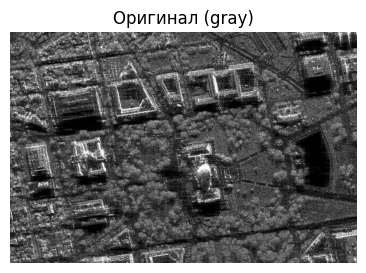

In [7]:
image = cv2.imread('sar_1_gray.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(6,3))
plt.imshow(image_gray, cmap='gray')
plt.title("Оригинал (gray)")
plt.axis("off")
plt.show()
print(" ")


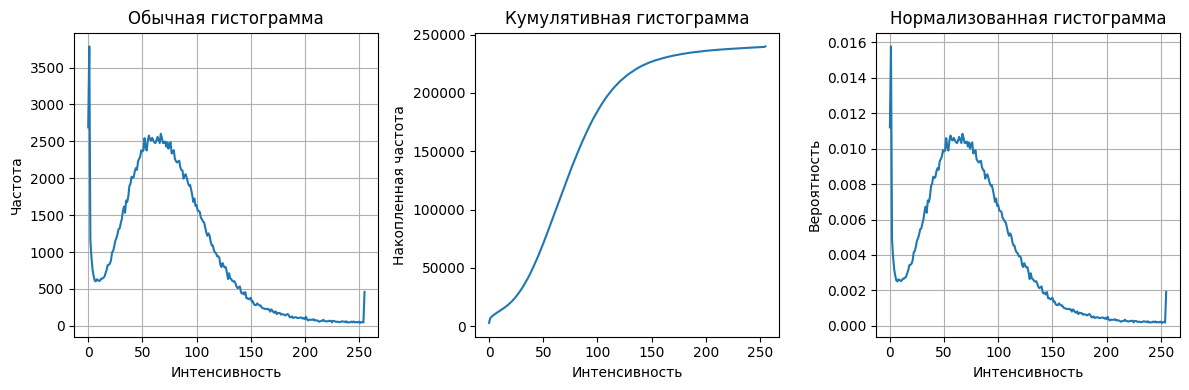

In [ ]:
hist = cv2.calcHist([image_gray], [0], None, [256], [0,256])
hist_cum = hist.cumsum()
hist_norm = hist / (image_gray.shape[0]*image_gray.shape[1])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(hist)
plt.title("Обычная гистограмма")
plt.xlabel("Интенсивность")
plt.ylabel("Частота")
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(hist_cum)
plt.title("Кумулятивная гистограмма")
plt.xlabel("Интенсивность")
plt.ylabel("Накопленная частота")
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(hist_norm)
plt.title("Нормализованная гистограмма")
plt.xlabel("Интенсивность")
plt.ylabel("Вероятность")
plt.grid(True)

plt.tight_layout()
plt.show()
print(" ")


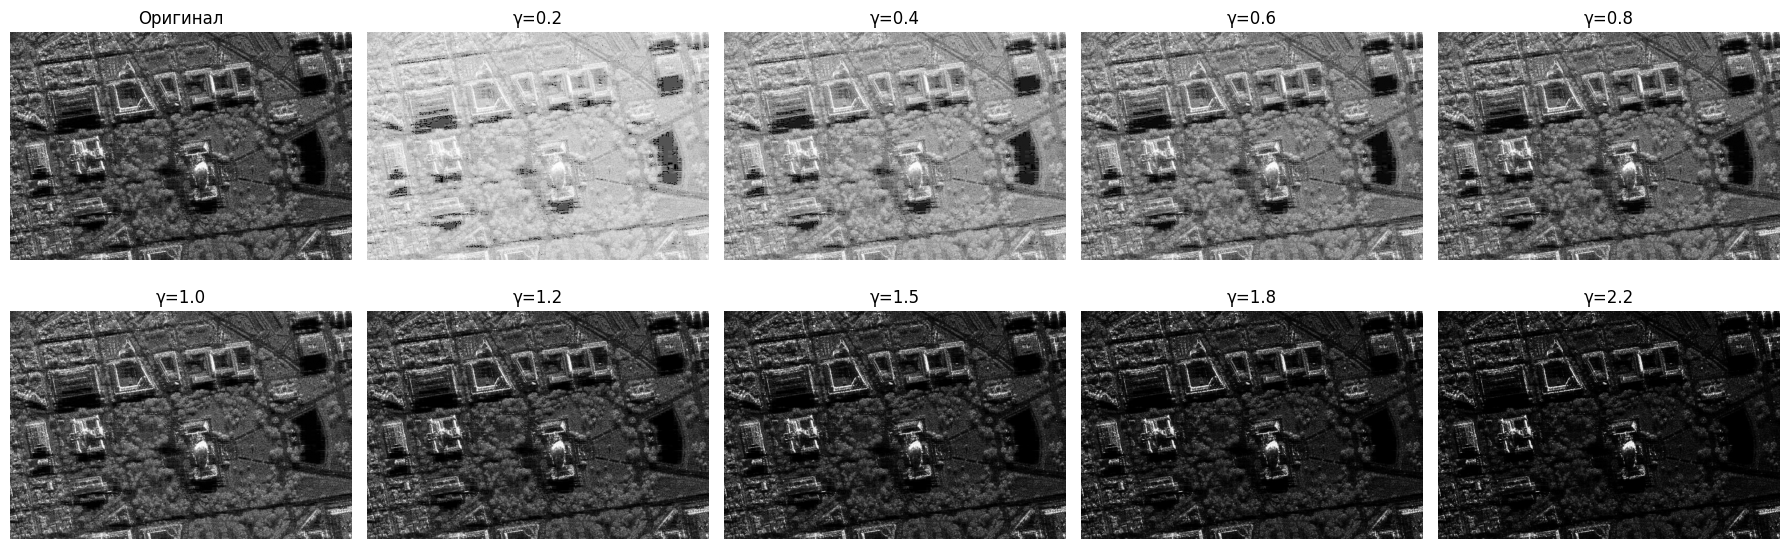

In [9]:
def gamma_correction(img, gamma):
    img_f = img.astype(np.float32)/255.0
    corrected = np.power(img_f, gamma)
    corrected = np.clip(corrected*255, 0, 255).astype(np.uint8)
    return corrected

gamma_values = [0.2,0.4,0.6,0.8,1.0,1.2,1.5,1.8,2.2]

plt.figure(figsize=(18,6))
plt.subplot(2,5,1)
plt.imshow(image_gray, cmap='gray')
plt.title("Оригинал")
plt.axis("off")

gamma_results = {}
for i, g in enumerate(gamma_values):
    corrected = gamma_correction(image_gray, g)
    gamma_results[g] = corrected
    plt.subplot(2,5,i+2)
    plt.imshow(corrected, cmap='gray')
    plt.title(f"γ={g}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(" ")


In [11]:
from skimage.metrics import structural_similarity, mean_squared_error

def mse(img1,img2):
    return np.mean((img1.astype(float)-img2.astype(float))**2)

def compute_ssim(img1,img2):
    return structural_similarity(img1,img2,data_range=255)

print(f"{'Gamma':>6} | {'MSE':>8} | {'SSIM':>8}")
print("-"*30)
for g,img_g in gamma_results.items():
    mse_val = mse(image_gray, img_g)
    ssim_val = compute_ssim(image_gray, img_g)
    print(f"{g:6} | {mse_val:8.2f} | {ssim_val:8.4f}")
print(" ")

 Gamma |      MSE |     SSIM
------------------------------
   0.2 | 14018.05 |   0.5027
   0.4 |  5517.94 |   0.7121
   0.6 |  1784.27 |   0.8535
   0.8 |   323.21 |   0.9600
   1.0 |     0.00 |   1.0000
   1.2 |   223.76 |   0.9572
   1.5 |   971.82 |   0.8066
   1.8 |  1837.90 |   0.6316
   2.2 |  2894.08 |   0.4356
 


Исходная статистика: mean=74.94, std=43.66
Целевая статистика (eq_gray): mean=127.03, std=74.27


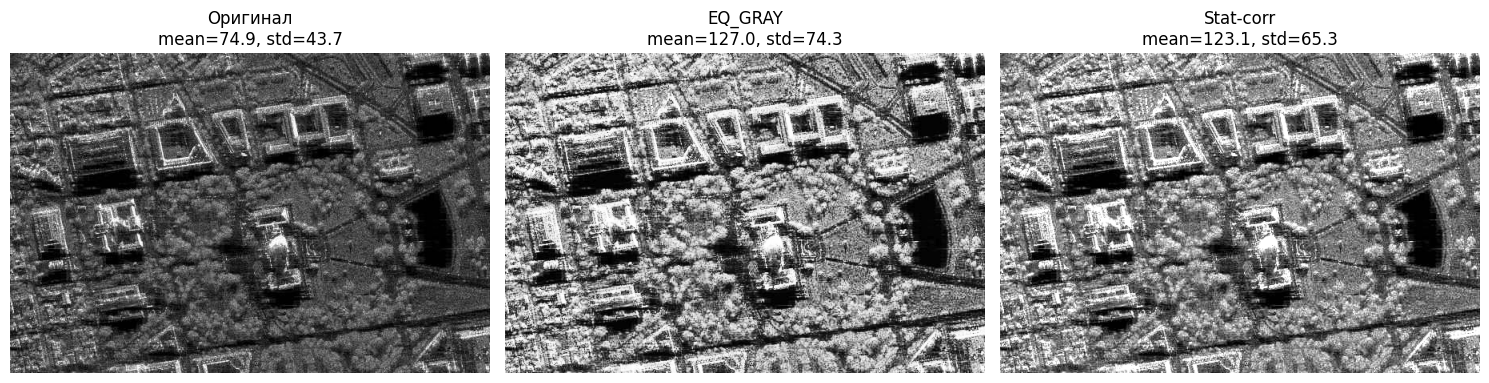

Stat-correction: MSE=2946.70, SSIM=0.7862
 


In [13]:
mean_src = image_gray.mean()
std_src = image_gray.std()
eq_gray = cv2.equalizeHist(image_gray)
mean_eq = eq_gray.mean()
std_eq = eq_gray.std()

print(f"Исходная статистика: mean={mean_src:.2f}, std={std_src:.2f}")
print(f"Целевая статистика (eq_gray): mean={mean_eq:.2f}, std={std_eq:.2f}")

if std_src>1e-6:
    corrected_stat = mean_eq + (image_gray.astype(float)-mean_src)*(std_eq/std_src)
else:
    corrected_stat = np.full_like(image_gray.astype(float), mean_eq)
corrected_stat = np.clip(corrected_stat,0,255).astype(np.uint8)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.imshow(image_gray, cmap='gray')
plt.title(f"Оригинал\nmean={mean_src:.1f}, std={std_src:.1f}")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(eq_gray, cmap='gray')
plt.title(f"EQ_GRAY\nmean={mean_eq:.1f}, std={std_eq:.1f}")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(corrected_stat, cmap='gray')
plt.title(f"Stat-corr\nmean={corrected_stat.mean():.1f}, std={corrected_stat.std():.1f}")
plt.axis("off")
plt.tight_layout()
plt.show()

mse_stat = mse(image_gray, corrected_stat)
ssim_stat = compute_ssim(image_gray, corrected_stat)
print(f"Stat-correction: MSE={mse_stat:.2f}, SSIM={ssim_stat:.4f}")
print(" ")

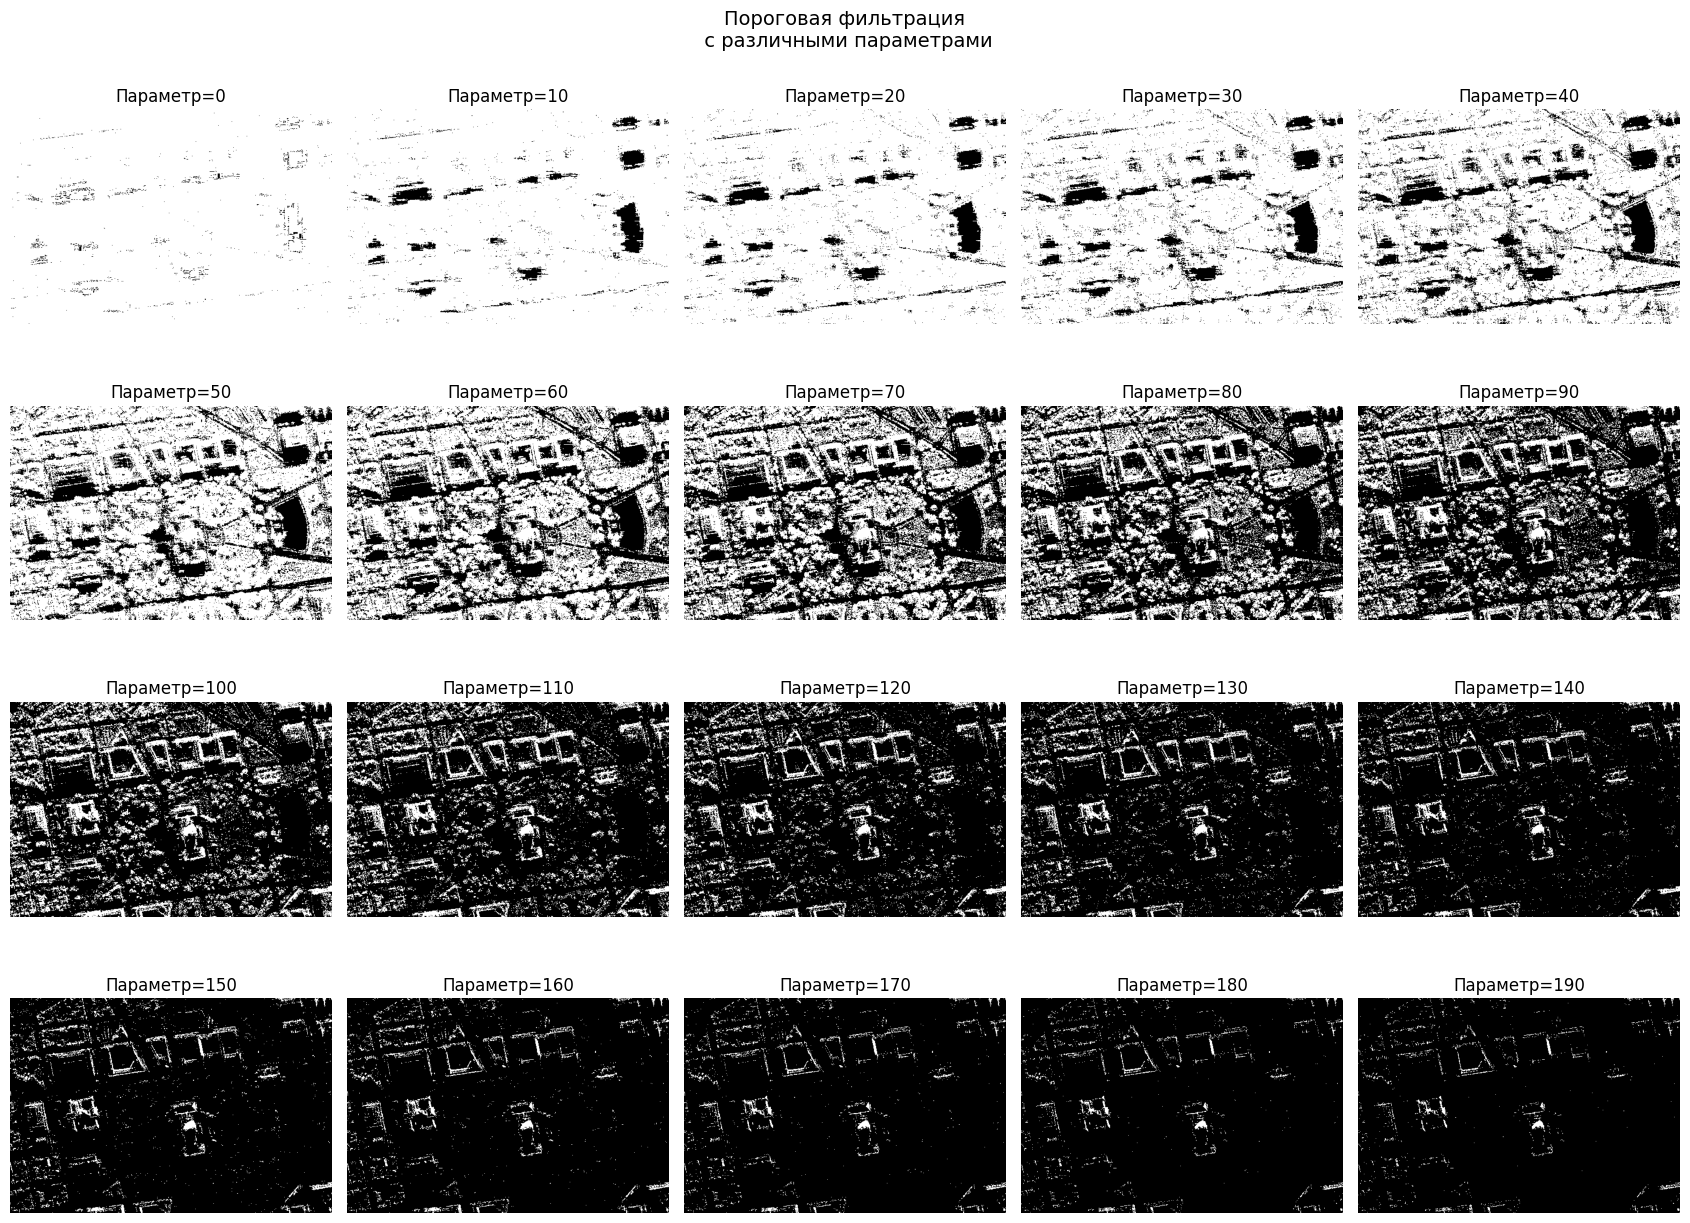

In [21]:
diff_values = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190]
plt.figure(figsize=(17, 13))
for i in range(0, 20):
    _,thresh1 = cv2.threshold(image_gray, diff_values[i] ,255,cv2.THRESH_BINARY)
    plt.subplot(4, 5, i+1)
    plt.imshow(thresh1, cmap='gray')
    plt.title(f"Параметр={diff_values[i]}")
    plt.axis('off')

plt.suptitle("Пороговая фильтрация\n с различными параметрами", fontsize=14)
plt.tight_layout()
plt.show()

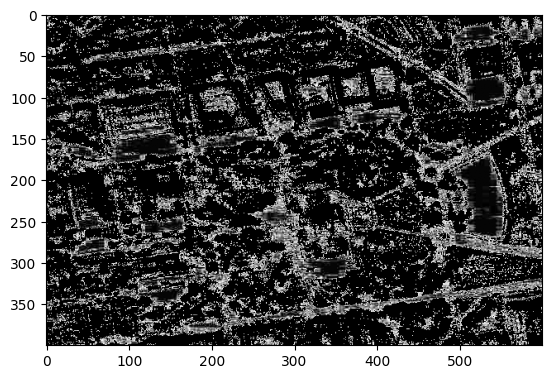